In [17]:
import os
import re
import glob
import gc

import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer

# =========================
# CONFIG
# =========================
BASE_DIR = r"E:/Data_for_Practice/JapMedia/"

SEARCH_DIRS = [
    os.path.join(BASE_DIR, "data/jap_data/translated"),
    os.path.join(BASE_DIR, "data/kor_data"),
]

BESTFRAME_PATTERN = "*bestframe_labels_specific*.csv"
EMBEDDING_NAME = "BAAI/bge-large-en-v1.5"
NEWSPAPERS = ["조선일보", "한겨레", "아사히신문", "요미우리신문"]

# =========================
# DEVICE & MODEL
# =========================
def pick_device():
    try:
        import torch
        return "cuda" if torch.cuda.is_available() else "cpu"
    except Exception:
        return "cpu"

DEVICE = pick_device()
print(f"[INFO] Using device: {DEVICE}")

embedding_model = SentenceTransformer(EMBEDDING_NAME, device=DEVICE)

def encode_texts(texts):
    return embedding_model.encode(
        texts,
        batch_size=64 if DEVICE == "cpu" else 256,
        show_progress_bar=True,
        convert_to_numpy=True,
        device=DEVICE,
    )

# =========================
# HELPER: file 컬럼에서 신문사/연도 추출
# =========================
def parse_from_row(file_value: str, source_file: str):
    """
    연도는 반드시 '20xx년도' 패턴에서만 추출.
    신문사는 NEWSPAPERS 리스트 중 file 또는 source_file에 포함된 것만 인정.
    """
    file_value = str(file_value)
    source_file = str(source_file)

    # ---- Newspaper ----
    newspaper = None
    for name in NEWSPAPERS:
        if name in file_value:
            newspaper = name
            break
    if newspaper is None:
        for name in NEWSPAPERS:
            if name in source_file:
                newspaper = name
                break

    # ---- Year: '20xx년도' 패턴에서만 추출 ----
    year_match = re.search(r"(20\d{2})\s*년도", file_value)
    year = int(year_match.group(1)) if year_match else None

    # ---- Country ----
    if newspaper in ["조선일보", "한겨레"]:
        country = "Korea"
    elif newspaper in ["아사히신문", "요미우리신문"]:
        country = "Japan"
    else:
        country = "UNKNOWN"

    return newspaper, year, country

# =========================
# MAIN: bestframe 레이블 임베딩 생성
# =========================
all_files = []
for d in SEARCH_DIRS:
    found = glob.glob(os.path.join(d, BESTFRAME_PATTERN))
    print(f"[INFO] Dir: {d}, Found: {len(found)} bestframe files")
    all_files.extend(found)

if not all_files:
    raise FileNotFoundError("[ERROR] No bestframe files found. Check SEARCH_DIRS / PATTERN.")

print(f"[INFO] Total bestframe files collected: {len(all_files)}")

all_rows = []

for fp in sorted(all_files):
    fname = os.path.basename(fp)
    print(f"\n[FILE] {fname}")

    df = pd.read_csv(fp, encoding="utf-8-sig")
    df = df[df.Topic != -1]
    print("  Columns:", df.columns.tolist())

    # 필수 컬럼 체크
    required_cols = ["file", "best_frame_label"]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        print(f"  [SKIP] Missing required columns: {missing}")
        continue

    # 레이블 = best_frame_label
    df["label"] = df["best_frame"].astype(str).str.strip()
    df = df[df["label"].str.len() > 0].copy()

    newspapers = []
    years = []
    countries = []

    for _, row in df.iterrows():
        file_val = row.get("file", "")
        source_file = fname  # fallback
        n, y, c = parse_from_row(file_val, source_file)
        newspapers.append(n)
        years.append(y)
        countries.append(c)

    df["newspaper"] = newspapers
    df["year"] = years
    df["country"] = countries
    df["source_file"] = fname

    valid = df[
        df["newspaper"].notna()
        & df["year"].notna()
        & (df["label"].str.len() > 0)
    ][["newspaper", "year", "country", "label", "source_file"]].copy()

    print(f"  Valid rows: {len(valid)}")
    if len(valid) == 0:
        continue

    all_rows.append(valid)

if not all_rows:
    raise RuntimeError("[ERROR] No valid rows from any bestframe file.")

combined = pd.concat(all_rows, ignore_index=True)
combined["newspaper"] = combined["newspaper"].astype(str).str.strip()
combined["year"] = pd.to_numeric(combined["year"], errors="coerce").astype("Int64")

print("\n[INFO] Combined rows BEFORE year filter:", len(combined))
print("[INFO] Years BEFORE filter:", combined["year"].unique())

# 🔒 연도는 2022, 2023, 2024만 허용 (그 외는 버림)
combined = combined[combined["year"].isin([2022, 2023, 2024])].copy()

print("[INFO] Combined rows AFTER year filter:", len(combined))
print("[INFO] Years AFTER filter:", combined["year"].unique())
print("[INFO] Newspapers:", combined["newspaper"].unique())

# 임베딩 계산
texts = combined["label"].tolist()
print("[INFO] Encoding label embeddings...")
emb = encode_texts(texts)

emb_cols = [f"emb_{i}" for i in range(emb.shape[1])]
emb_df = pd.DataFrame(emb, columns=emb_cols)

combined = combined.reset_index(drop=True)
combined_with_emb = pd.concat([combined, emb_df], axis=1)

out_path = os.path.join(BASE_DIR, "all_topic_label_embeddings.csv")
combined_with_emb.to_csv(out_path, index=False, encoding="utf-8-sig")
print(f"[SAVED] {out_path}")

del combined, combined_with_emb, emb_df
gc.collect()


[INFO] Using device: cuda
[INFO] Dir: E:/Data_for_Practice/JapMedia/data/jap_data/translated, Found: 1 bestframe files
[INFO] Dir: E:/Data_for_Practice/JapMedia/data/kor_data, Found: 1 bestframe files
[INFO] Total bestframe files collected: 2

[FILE] bestframe_labels_specific_JP.csv
  Columns: ['file', 'Topic', 'Count', 'Representation', 'best_frame', 'best_frame_label', 'confidence', 'source']
  Valid rows: 20

[FILE] bestframe_labels_specific_KR.csv
  Columns: ['file', 'Topic', 'Count', 'Representation', 'best_frame', 'best_frame_label', 'confidence', 'source']
  Valid rows: 23

[INFO] Combined rows BEFORE year filter: 43
[INFO] Years BEFORE filter: <IntegerArray>
[2022, 2023, 2024]
Length: 3, dtype: Int64
[INFO] Combined rows AFTER year filter: 43
[INFO] Years AFTER filter: <IntegerArray>
[2022, 2023, 2024]
Length: 3, dtype: Int64
[INFO] Newspapers: ['아사히신문' '요미우리신문' '조선일보' '한겨레']
[INFO] Encoding label embeddings...


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.88it/s]

[SAVED] E:/Data_for_Practice/JapMedia/all_topic_label_embeddings.csv

25918

Years in embedding file: <IntegerArray>
[2022, 2023, 2024]
Length: 3, dtype: Int64

=== Centroid groups ===
   newspaper  year
0      아사히신문  2022
1      아사히신문  2023
2      아사히신문  2024
3     요미우리신문  2022
4     요미우리신문  2023
5     요미우리신문  2024
6       조선일보  2022
7       조선일보  2023
8       조선일보  2024
9        한겨레  2022
10       한겨레  2023
11       한겨레  2024


c:\ProgramData\anaconda3\envs\rtx5090\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[FIG SAVED] E:/Data_for_Practice/JapMedia/umap_centroid_by_year_no_lines.png


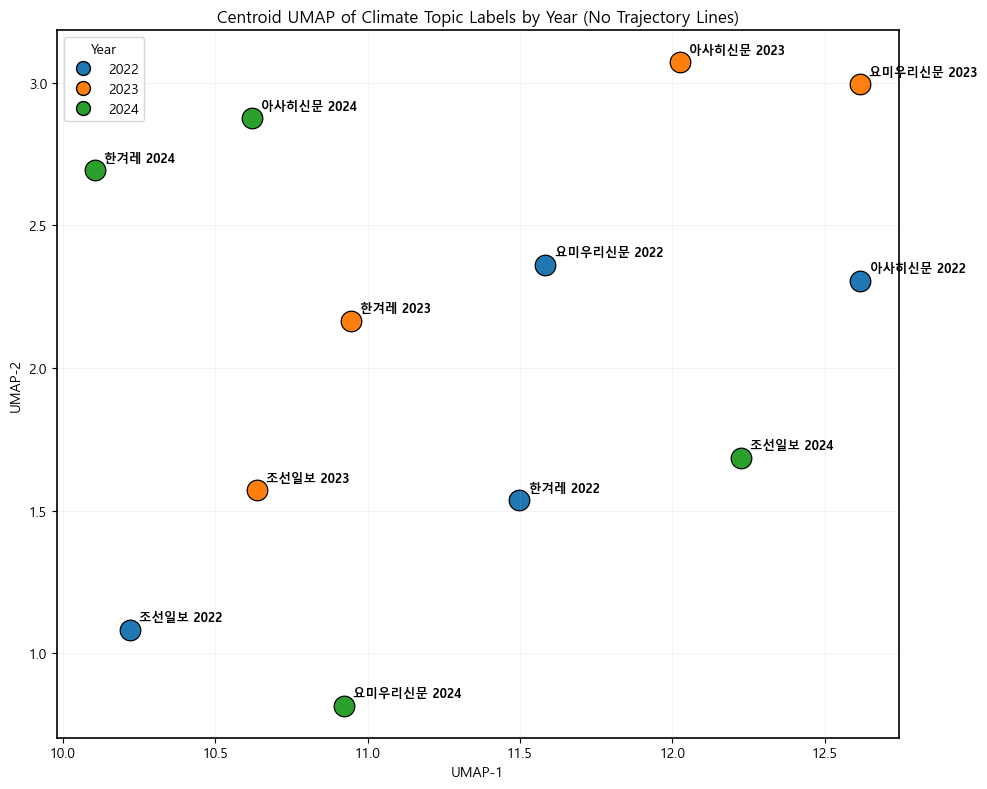

In [18]:
import os
import pandas as pd
from umap import UMAP
import matplotlib.pyplot as plt

# 한글 폰트 (Windows 기준)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

BASE_DIR = r"E:/Data_for_Practice/JapMedia/"
embedding_csv_path = os.path.join(BASE_DIR, "all_topic_label_embeddings.csv")

df = pd.read_csv(embedding_csv_path, encoding="utf-8-sig")

df["newspaper"] = df["newspaper"].astype(str).str.strip()
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")

emb_cols = [c for c in df.columns if c.startswith("emb_")]
if not emb_cols:
    raise RuntimeError("[ERROR] No embedding columns (emb_*) found in CSV.")

print("Years in embedding file:", df["year"].unique())

# 신문사 × 연도별 센트로이드
centroids = (
    df
    .groupby(["newspaper", "year"])
    [emb_cols]
    .mean()
    .reset_index()
)

print("\n=== Centroid groups ===")
print(centroids[["newspaper", "year"]])

X = centroids[emb_cols].values

umap_model = UMAP(
    n_neighbors=10,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)
coords = umap_model.fit_transform(X)

centroids["x"] = coords[:, 0]
centroids["y"] = coords[:, 1]

# 🔹 연도별 색상 매핑
color_map_year = {
    2022: "#1f77b4",  # blue
    2023: "#ff7f0e",  # orange
    2024: "#2ca02c",  # green
}

plt.figure(figsize=(10, 8))

# 점만 표시 (도형 통일 → 원형)
for _, row in centroids.iterrows():
    yr = int(row["year"])
    plt.scatter(
        row["x"],
        row["y"],
        color=color_map_year.get(yr, "gray"),
        s=220,
        edgecolors="black",
        linewidths=0.9
    )
    plt.text(
        row["x"] + 0.03,
        row["y"] + 0.03,
        f"{row['newspaper']} {row['year']}",
        fontsize=9,
        weight="bold"
    )

# 연도 범례
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='white',
               label='2022', markerfacecolor=color_map_year[2022],
               markeredgecolor='black', markersize=10),
    plt.Line2D([0], [0], marker='o', color='white',
               label='2023', markerfacecolor=color_map_year[2023],
               markeredgecolor='black', markersize=10),
    plt.Line2D([0], [0], marker='o', color='white',
               label='2024', markerfacecolor=color_map_year[2024],
               markeredgecolor='black', markersize=10),
]
plt.legend(handles=legend_handles, title="Year")

plt.title("Centroid UMAP of Climate Topic Labels by Year (No Trajectory Lines)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(alpha=0.15)
plt.tight_layout()

out_fig = os.path.join(BASE_DIR, "umap_centroid_by_year_no_lines.png")
plt.savefig(out_fig, dpi=300)
print(f"[FIG SAVED] {out_fig}")

plt.show()


Years in embedding file: <IntegerArray>
[2022, 2023, 2024]
Length: 3, dtype: Int64


c:\ProgramData\anaconda3\envs\rtx5090\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[FIG SAVED] E:/Data_for_Practice/JapMedia/umap_centroid_by_year_3D.png


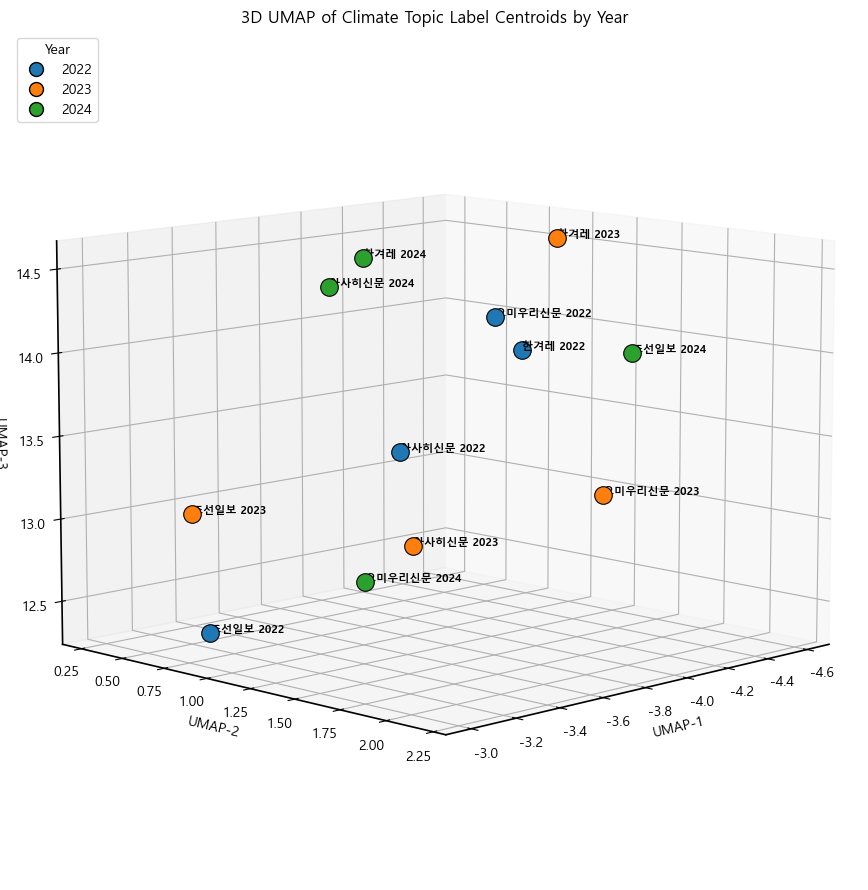

In [19]:
import os
import pandas as pd
from umap import UMAP
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D projection

# 한글 폰트(Windows)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

BASE_DIR = r"E:/Data_for_Practice/JapMedia/"
embedding_csv_path = os.path.join(BASE_DIR, "all_topic_label_embeddings.csv")

df = pd.read_csv(embedding_csv_path, encoding="utf-8-sig")

df["newspaper"] = df["newspaper"].astype(str).str.strip()
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")

emb_cols = [c for c in df.columns if c.startswith("emb_")]
if not emb_cols:
    raise RuntimeError("[ERROR] No embedding columns found!")

print("Years in embedding file:", df["year"].unique())

# ====== 신문사 × 연도별 센트로이드 ======
centroids = (
    df
    .groupby(["newspaper", "year"])
    [emb_cols]
    .mean()
    .reset_index()
)

X = centroids[emb_cols].values

# ====== 3D UMAP ======
umap_model = UMAP(
    n_neighbors=10,
    min_dist=0.1,
    n_components=3,
    metric="cosine",
    random_state=42,
)
coords = umap_model.fit_transform(X)

centroids["x"] = coords[:, 0]
centroids["y"] = coords[:, 1]
centroids["z"] = coords[:, 2]

# ====== 색 (연도별) ======
color_map_year = {
    2022: "#1f77b4",  # blue
    2023: "#ff7f0e",  # orange
    2024: "#2ca02c",  # green
}

# ====== 3D Plot ======
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(111, projection="3d")

for _, row in centroids.iterrows():
    yr = int(row["year"])
    ax.scatter(
        row["x"], row["y"], row["z"],
        color=color_map_year.get(yr, "gray"),
        s=160,
        edgecolors="black",
        linewidths=0.8
    )
    ax.text(
        row["x"], row["y"], row["z"],
        f"{row['newspaper']} {row['year']}",
        fontsize=8,
        weight="bold"
    )

# ====== 범례(연도) ======
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='white',
               label='2022', markerfacecolor=color_map_year[2022],
               markeredgecolor='black', markersize=10),
    plt.Line2D([0], [0], marker='o', color='white',
               label='2023', markerfacecolor=color_map_year[2023],
               markeredgecolor='black', markersize=10),
    plt.Line2D([0], [0], marker='o', color='white',
               label='2024', markerfacecolor=color_map_year[2024],
               markeredgecolor='black', markersize=10),
]
ax.legend(handles=legend_handles, title="Year", loc="upper left")

ax.set_title("3D UMAP of Climate Topic Label Centroids by Year")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_zlabel("UMAP-3")

# 회전 가능하게
ax.view_init(elev=10, azim=45)

plt.tight_layout()
out_fig = os.path.join(BASE_DIR, "umap_centroid_by_year_3D.png")
plt.savefig(out_fig, dpi=300)
print(f"[FIG SAVED] {out_fig}")

plt.show()


In [20]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_distances

BASE_DIR = r"E:/Data_for_Practice/JapMedia/"
df = pd.read_csv(os.path.join(BASE_DIR, "all_topic_label_embeddings.csv"), encoding="utf-8-sig")

# 센트로이드 재계산 (신문사 × 연도)
emb_cols = [c for c in df.columns if c.startswith("emb_")]
centroids = df.groupby(["newspaper", "year"])[emb_cols].mean()

# 거리 행렬 (cosine distance)
dist_matrix = cosine_distances(centroids.values)

labels = [f"{n}-{y}" for n, y in centroids.index]
dist_df = pd.DataFrame(dist_matrix, index=labels, columns=labels)

out_path = os.path.join(BASE_DIR, "semantic_distance_matrix.csv")
dist_df.to_csv(out_path, encoding="utf-8-sig")

print("[SAVED] Semantic distance matrix:", out_path)
dist_df


[SAVED] Semantic distance matrix: E:/Data_for_Practice/JapMedia/semantic_distance_matrix.csv


,아사히신문-2022,아사히신문-2023,아사히신문-2024,요미우리신문-2022,요미우리신문-2023,요미우리신문-2024,조선일보-2022,조선일보-2023,조선일보-2024,한겨레-2022,한겨레-2023,한겨레-2024
아사히신문-2022,0.000000,0.012652,0.035941,1.265215e-02,0.000000,0.040328,0.109901,0.033508,1.265215e-02,2.781202e-02,2.781202e-02,0.096748
아사히신문-2023,0.012652,0.000000,0.072553,5.028845e-02,0.012652,0.069509,0.119292,0.064799,5.028845e-02,7.724953e-02,7.724953e-02,0.168136
아사히신문-2024,0.035941,0.072553,0.000000,2.372321e-02,0.035941,0.051921,0.116714,0.036297,2.372321e-02,2.669299e-02,2.669299e-02,0.027065
요미우리신문-2022,0.012652,0.050288,0.023723,0.000000e+00,0.012652,0.035430,0.123033,0.026674,1.110223e-16,2.975057e-03,2.975057e-03,0.048217
요미우리신문-2023,0.000000,0.012652,0.035941,1.265215e-02,0.000000,0.040328,0.109901,0.033508,1.265215e-02,2.781202e-02,2.781202e-02,0.096748
요미우리신문-2024,0.040328,0.069509,0.051921,3.543044e-02,0.040328,0.000000,0.039361,0.005951,3.543044e-02,4.185164e-02,4.185164e-02,0.086590
조선일보-2022,0.109901,0.119292,0.116714,1.230332e-01,0.109901,0.039361,0.000000,0.037807,1.230332e-01,1.374192e-01,1.374192e-01,0.175186
조선일보-2023,0.033508,0.064799,0.036297,2.667408e-02,0.033508,0.005951,0.037807,0.000000,2.667408e-02,3.223387e-02,3.223387e-02,0.068968
조선일보-2024,0.012652,0.050288,0.023723,1.110223e-16,0.012652,0.035430,0.123033,0.026674,0.000000e+00,2.975057e-03,2.975057e-03,0.048217
한겨레-2022,0.027812,0.077250,0.026693,2.975057e-03,0.027812,0.041852,0.137419,0.032234,2.975057e-03,0.000000e+00,2.220446e-16,0.033311


In [21]:
import os
import pandas as pd
import numpy as np

BASE_DIR = r"E:/Data_for_Practice/JapMedia/"
dist_df = pd.read_csv(os.path.join(BASE_DIR, "semantic_distance_matrix.csv"), index_col=0)

labels = dist_df.index.tolist()

# --- 메타 정보 추출 ---
newspaper = [x.split("-")[0] for x in labels]
year = [int(x.split("-")[1]) for x in labels]

ideology_map = {
    "조선일보": "Conservative",
    "요미우리신문": "Conservative",
    "한겨레": "Progressive",
    "아사히신문": "Progressive",
}
country_map = {
    "조선일보": "Korea",
    "한겨레": "Korea",
    "아사히신문": "Japan",
    "요미우리신문": "Japan",
}

ideology = [ideology_map[n] for n in newspaper]
country = [country_map[n] for n in newspaper]

# 🔹 dist_df의 인덱스와 meta 인덱스를 맞춤
meta = pd.DataFrame(
    {
        "label": labels,
        "newspaper": newspaper,
        "year": year,
        "ideology": ideology,
        "country": country,
    },
    index=dist_df.index,
)

rows = []
years_unique = sorted(meta["year"].unique())

for y in years_unique:
    # ---- 1) 한국 내부 보수–진보: 조선일보 vs 한겨레 ----
    mask_K_con = (meta["newspaper"] == "조선일보") & (meta["year"] == y)
    mask_K_pro = (meta["newspaper"] == "한겨레") & (meta["year"] == y)
    if mask_K_con.any() and mask_K_pro.any():
        d_K_ideo = dist_df.loc[mask_K_con, mask_K_pro].to_numpy().mean()
        rows.append({
            "Year": y,
            "Comparison": "Korea: Conservative vs Progressive",
            "Cosine Distance": d_K_ideo,
        })

    # ---- 2) 일본 내부 보수–진보: 요미우리 vs 아사히 ----
    mask_J_con = (meta["newspaper"] == "요미우리신문") & (meta["year"] == y)
    mask_J_pro = (meta["newspaper"] == "아사히신문") & (meta["year"] == y)
    if mask_J_con.any() and mask_J_pro.any():
        d_J_ideo = dist_df.loc[mask_J_con, mask_J_pro].to_numpy().mean()
        rows.append({
            "Year": y,
            "Comparison": "Japan: Conservative vs Progressive",
            "Cosine Distance": d_J_ideo,
        })

    # ---- 3) 한국 vs 일본 (그 연도 기준 국가 간 차이) ----
    mask_K = (meta["country"] == "Korea") & (meta["year"] == y)
    mask_J = (meta["country"] == "Japan") & (meta["year"] == y)
    if mask_K.any() and mask_J.any():
        d_country = dist_df.loc[mask_K, mask_J].to_numpy().mean()
        rows.append({
            "Year": y,
            "Comparison": "Korea vs Japan (all outlets)",
            "Cosine Distance": d_country,
        })

summary = pd.DataFrame(rows)
summary = summary.sort_values(["Year", "Comparison"]).reset_index(drop=True)

print(summary)

out_path = os.path.join(BASE_DIR, "semantic_distance_summary_by_year.csv")
summary.to_csv(out_path, index=False, encoding="utf-8-sig")
print(f"[SAVED] {out_path}")


   Year                          Comparison  Cosine Distance
0  2022  Japan: Conservative vs Progressive         0.012652
1  2022        Korea vs Japan (all outlets)         0.065930
2  2022  Korea: Conservative vs Progressive         0.137419
3  2023  Japan: Conservative vs Progressive         0.012652
4  2023        Korea vs Japan (all outlets)         0.050842
5  2023  Korea: Conservative vs Progressive         0.032234
6  2024  Japan: Conservative vs Progressive         0.051921
7  2024        Korea vs Japan (all outlets)         0.043202
8  2024  Korea: Conservative vs Progressive         0.048217
[SAVED] E:/Data_for_Practice/JapMedia/semantic_distance_summary_by_year.csv


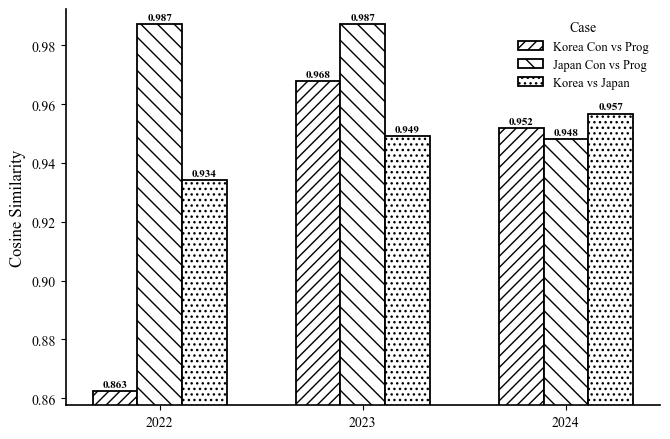

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

BASE_DIR = r"E:/Data_for_Practice/JapMedia/"
summary_path = os.path.join(BASE_DIR, "semantic_distance_summary_by_year.csv")
df = pd.read_csv(summary_path, encoding="utf-8-sig")

# similarity 추가
df["Cosine Similarity"] = 1 - df["Cosine Distance"]

# 라벨 단축 (원하면)
label_map = {
    "Korea: Conservative vs Progressive": "Korea Con vs Prog",
    "Japan: Conservative vs Progressive": "Japan Con vs Prog",
    "Korea vs Japan (all outlets)": "Korea vs Japan",
}
df["Case"] = df["Comparison"].map(label_map)

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.2

cases = ["Korea Con vs Prog", "Japan Con vs Prog", "Korea vs Japan"]
patterns = ["///", "\\\\", "..."]

years = sorted(df["Year"].unique())
x = np.arange(len(years))
width = 0.22

fig, ax = plt.subplots(figsize=(6.8, 4.5))

for i, case in enumerate(cases):
    subset = df[df["Case"] == case].sort_values("Year")
    yvals = subset["Cosine Similarity"].values

    bars = ax.bar(
        x + (i - 1) * width,
        yvals,
        width=width,
        color="white",
        edgecolor="black",
        linewidth=1.3,
        label=case
    )
    for bar in bars:
        bar.set_hatch(patterns[i])

    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            h + 0.0007,
            f"{h:.3f}",
            ha="center", va="bottom",
            fontsize=8,
            fontweight="bold"
        )

ax.set_ylabel("Cosine Similarity", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(years)

ymin = df["Cosine Similarity"].min() - 0.005
ymax = df["Cosine Similarity"].max() + 0.005
ax.set_ylim(ymin, ymax)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(title="Case", frameon=False, fontsize=9)

plt.tight_layout()
plt.show()